In [2]:
%matplotlib inline
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

DATASET_PATH = './augmented/'

In [3]:
files = os.listdir(DATASET_PATH)

rawx=[]
rawy=[]
for file in files:
    img = cv2.imread(os.path.join(DATASET_PATH,file),cv2.IMREAD_GRAYSCALE)
    rawx.append(img)
    u = file.split('_')
    rawy.append(u[2])

In [4]:
im_h, im_w = rawx[0].shape
num_classes = len(np.unique(rawy))

In [5]:
x = np.asarray(rawx)
y = np.asarray(rawy)
x = x.reshape(len(files),im_h*im_w)
print(x.shape)
print(y.shape)

(5400, 2500)
(5400,)


In [6]:
rawx= None
rawy= None

In [7]:
x = x / 255.

In [8]:
np.unique(y)

array(['0', '1', '2', '3', '4', '5'], dtype='<U1')

In [9]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.2,stratify=y)

In [10]:
x = None
y = None

In [11]:
def plot_6_images(xt,yt):
    
    idxs = [ random.randint(0,len(xt)) for i in range(0,6)]
    plt.figure(figsize=(10,5))
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.imshow(xt[idxs[i]].reshape(im_w,im_h),cmap='gray')
        plt.title('y={}'.format(yt[idxs[i]]))
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()  

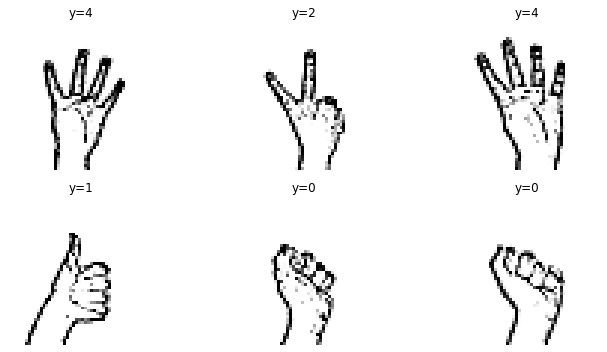

In [12]:
plot_6_images(xtrain,ytrain)

In [14]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
%time X_reduced = pca.fit_transform(xtrain)

Wall time: 6.19 s


In [15]:
print('dimension reduction from %d to %d after PCA preserving 95%% of variance' % (xtrain.shape[1],pca.n_components_))

dimension reduction from 2500 to 689 after PCA preserving 95% of variance


check how pictures looks like after PCA

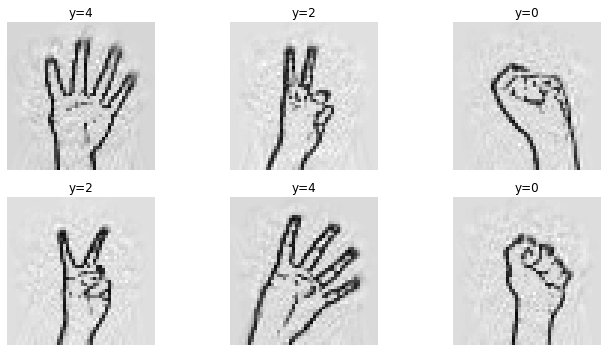

In [18]:
images = pca.inverse_transform(X_reduced)
plot_6_images(images,ytrain)

In [25]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
ytrain_enc = encoder.fit_transform(ytrain)
print("ytrain: ",ytrain[:10])
print("ytrain_enc: ",ytrain_enc[:10])

ytest_enc = encoder.fit_transform(ytest)

ytrain:  ['0' '1' '2' '3' '4' '0' '2' '0' '5' '0']
ytrain_enc:  [0 1 2 3 4 0 2 0 5 0]


Try different classifiers with default parameters

In [28]:
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

classifs = [
           SGDClassifier(random_state=37), 
           KNeighborsClassifier(),
           DecisionTreeClassifier(),
           SVC(),
           RandomForestClassifier(random_state=37),
           AdaBoostClassifier(random_state=37),
           ]

classif_names=[
               'SGD\t\t',
               'KNN\t\t', 
               'DecisionTree\t', 
               'SVC\t\t',
               'RandomForest\t',
               'AdaBoost\t\t',
               ]

# Apply different classifiers

for name, clf in zip(classif_names, classifs):
    %time score = cross_val_score(clf, xtrain, ytrain_enc, cv=3, scoring="accuracy")
    print("%s : %s Score :" % (name,score), " Worst: %.4f" % score.min())


Wall time: 3.64 s
SGD		 : [0.94652778 0.97291667 0.97152778] Score :  Worst: 0.9465
Wall time: 44.3 s
KNN		 : [0.92638889 0.93125    0.91666667] Score :  Worst: 0.9167
Wall time: 3.27 s
DecisionTree	 : [0.80416667 0.81111111 0.80416667] Score :  Worst: 0.8042
Wall time: 1min 34s
SVC		 : [0.9875     0.99236111 0.99791667] Score :  Worst: 0.9875
Wall time: 6.15 s
RandomForest	 : [0.97708333 0.98125    0.975     ] Score :  Worst: 0.9750
Wall time: 31.1 s
AdaBoost		 : [0.51805556 0.52847222 0.48472222] Score :  Worst: 0.4847


SGDClassifier (using linear SVM) and Random Frorest give good results in quite small time.
Try to fine tune those two models to improve performance.

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {
        'hidden_layer_sizes':[(100,),(100,10)],
        'activation':['logistic', 'relu'],
        'solver':['sgd','adam'],
        'learning_rate_init':[0.001,0.01,0.1],
    }
]

clf = SGDClassifier(random_state=37)
grid_search = GridSearchCV(clf,param_grid,cv=3,return_train_score=True)
grid_search.fit(xtrain,ytrain_enc);